# Assignment 1: Benchmarking Neural Nets with the XOR Problem

### DS 6050 - School of Data Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For deliverables, you must write code in Python/Pytorch and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 80 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_1_ann.ipynb**.



In [1]:
# You might want to use the following packages
import numpy as np
import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial
from torch.utils.data import DataLoader, TensorDataset


2.5.1+cpu


---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the `train / validate / test` sets. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)


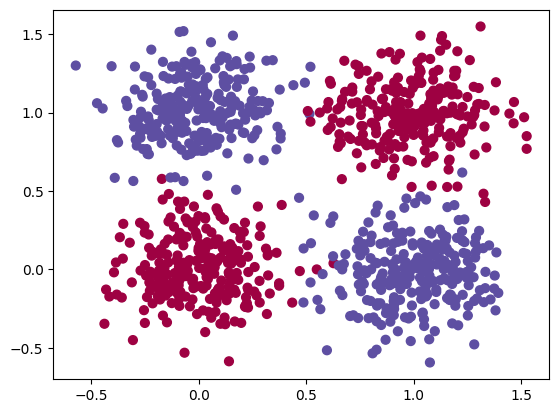

In [2]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.

In [3]:
class net(nn.Module):

  # Hyperbolic tangent can be achieved with torch.tanh()
  # Use any optimizer to optimize model parameters
  # An example can be found at: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

  def __init__(self):

    super().__init__()
    self.flatten = nn.Flatten()

    self.linear_relu_stack = nn.Sequential(
      nn.Linear(2, 10),
      nn.ReLU(),
      nn.Linear(10,10),
      nn.ReLU(),
      nn.Linear(10,2),
    )

  def forward(self, x):

    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    
    return logits
  
model = net()

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [5]:
dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)  # Create DataLoader

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)  # Create DataLoader

In [ ]:
batch_size = 32

def train_loop(dataloader_train, model, loss_fn, optimizer):
    size = len(dataloader_train)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, (X, y) in enumerate(dataloader_train):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader_test, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader_test.dataset)
    num_batches = len(dataloader_test)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader_test:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_loop(dataloader_test, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.688616  [   32/   23]
Test Error: 
 Accuracy: 48.5%, Avg loss: 0.714707 

Epoch 2
-------------------------------
loss: 0.699740  [   32/   23]
Test Error: 
 Accuracy: 48.5%, Avg loss: 0.706875 

Epoch 3
-------------------------------
loss: 0.701114  [   32/   23]
Test Error: 
 Accuracy: 48.5%, Avg loss: 0.702659 

Epoch 4
-------------------------------
loss: 0.718889  [   32/   23]
Test Error: 
 Accuracy: 48.5%, Avg loss: 0.705073 

Epoch 5
-------------------------------
loss: 0.719226  [   32/   23]
Test Error: 
 Accuracy: 48.5%, Avg loss: 0.701091 

Epoch 6
-------------------------------
loss: 0.705635  [   32/   23]
Test Error: 
 Accuracy: 48.5%, Avg loss: 0.700708 

Epoch 7
-------------------------------
loss: 0.704583  [   32/   23]
Test Error: 
 Accuracy: 48.5%, Avg loss: 0.699654 

Epoch 8
-------------------------------
loss: 0.700626  [   32/   23]
Test Error: 
 Accuracy: 48.5%, Avg loss: 0.697573 

Epoch 9
----------------

In [8]:
# Accuracy for Validation Set

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)  # Create DataLoader

test_loop(dataloader_val, model, loss_fn)


Test Error: 
 Accuracy: 92.5%, Avg loss: 0.396851 



- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [18]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder

class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, n0, n1, n2, alpha=0.01):
        """
        @param: n0: Number of nodes in the input layer
        @param: n1: Number of nodes in the hidden layer
        @param: n2: Number of nodes in the output layer
        @param: alpha: The Learning Rate
        """

        # SUBTASK 1: Initialize the parameters to random values.
        np.random.seed(42)
        
        self.W1 = np.random.randn(n1, n0) * 0.01
        self.b1 = np.zeros((n1, 1)) 
        self.W2 = np.random.randn(n2, n1) * 0.01
        self.b2 = np.zeros((n2, 1))

        # Configure the learning rate
        self.alpha = alpha
        # One-hot encoder for labels
        self.encoder = OneHotEncoder(sparse_output=False)

    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: A1: saved value of the output of the hidden layer
        @return: A2: activated return value of the output layer.
        """
        # SUBTASK 2: Implement Forward propagation.
        # Note: that you must implement tanh activation for the hiden layer
        # and softmax for the output layer

        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)

        Z2 = np.dot(self.W2, A1) + self.b2
        
        A2 = np.exp(Z2)/np.sum(np.exp(Z2), axis=0, keepdims = True)

        return A1, A2


    def loss(self, X, y):
        """
        Evaluate the total loss on the dataset
        @param: X: features
        @param: y: labels
        @return: L: the loss value
        """

        # SUBTASK 3: Calculate the loss using Cross-Entropy
        # You will need to return the average loss on the data
        # Hint: Use A2 to calculate the loss
        A1, A2 = self.forward_pass(X)
        # Another Hint: First, you may want to convert the lable y into a one-hot vector
        Y = self.one_hot(y)
        
        L = -np.sum(Y*np.log2(A2))

        return L

    def backward_pass(self, A1, A2, X, y):
        """
        @param: X: feature
        @param: y: label
        @param: A1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the loss gradient of W1
        @return: db1: the loss gradient of b1
        @return: dW2: the loss gradient of W2
        @return: db2: the loss gradient of b2
        """

        # You DO NOT CHANGE this function, ... NOT TRUE!!!!!!!!!!!!
        # unless you are advanced and want to use different activation function for your forward pass
        # This is an elegant partial derivative of cross entropy with softmax
        # Ref document: https://deepnotes.io/softmax-crossentropy
        # feel free to cross check the calculated gradients with autograd from Pytorch
        # Ref document: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
        m = y.shape[0]
        dZ2 = A2 - self.one_hot(y) # removed transpose !!!!!!
        dW2 = np.dot(dZ2, A1.T)/m
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m
        dZ1 = np.multiply(np.dot(self.W2.T, dZ2), 1-np.power(A1, 2))
        dW1 = np.dot(dZ1, X.T)/m
        db1 = (np.sum(dZ1, axis=1, keepdims=True)/m)

        return dW1, db1, dW2, db2


    def fit(self, X, y , epochs, X_val, y_val):
        """
        Learns parameters for the neural network and returns the model.

        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Input checks: X and X_val needs to be in the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T
        if (X_val.shape[0] > X_val.shape[1]): X_val = X_val.T

        # Gradient descent
        for i in range(0, epochs):

            # SUBTASK 4: Compute the forward, backward, and gradient descent parameter update
            # Step 1: Forward pass
            A1, A2 = self.forward_pass(X)

            # Step 2: Backward pass
            dW1, db1, dW2, db2 = self.backward_pass(A1, A2, X, y)

            # Step 3: Gradient Descent
            self.W1 = self.W1 - (dW1*self.alpha)
            self.b1 = self.b1 - (db1*self.alpha) 
            self.W2 = self.W2 - (dW2*self.alpha)
            self.b2 = self.b2 - (db2*self.alpha)

            # Print the loss and validation accuracy every 10 epochs.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_accuracy: %f"
                      %(i,epochs, self.loss(X, y), self.evaluate(X, y),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

    def predict(self, X):
        """
        Predict label vector y
        """
        # check X for the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T

        # SUBTASK 5: Implement the prediction process.
        # Hint: It should include a forward pass, and then use the class with higher probability.
        
        A1, A2 = self.forward_pass(X)
        
        y_hat = np.argmax(A2, axis=0)
        
        return y_hat


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        m = y.shape[0]
        y_hat = self.predict(X)

        y = np.array(y)
        correct_y = (y_hat == y).astype(int)

        return sum(correct_y)/m


    def one_hot(self, y):
        """
        Utility function: Convert a label vector to one-hot vector
        """
        Y = self.encoder.fit_transform(y.reshape(len(y),1))
        return Y.T # Transpose to get into same shape 1 x 


    def plot_decision_boundary(self, X, y):
        """
        Utility Function: Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        data_grid= np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(data_grid)
        Z = Z.reshape(xx.shape)

        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version.

Epoch 0/10 - loss: 719.958734 - accuracy: 0.513889 - val_loss: 80.029516 - val_accuracy: 0.412500
Accuracy on the test set is  0.485
Epoch 0/10 - loss: 719.727267 - accuracy: 0.513889 - val_loss: 80.251465 - val_accuracy: 0.412500
Accuracy on the test set is  0.485
Epoch 0/10 - loss: 719.644222 - accuracy: 0.513889 - val_loss: 80.390434 - val_accuracy: 0.412500
Accuracy on the test set is  0.485
Epoch 0/10 - loss: 719.614279 - accuracy: 0.513889 - val_loss: 80.475809 - val_accuracy: 0.412500
Accuracy on the test set is  0.485
Epoch 0/10 - loss: 719.603338 - accuracy: 0.513889 - val_loss: 80.527708 - val_accuracy: 0.412500
Accuracy on the test set is  0.485
Epoch 0/10 - loss: 719.599197 - accuracy: 0.513889 - val_loss: 80.559074 - val_accuracy: 0.412500
Accuracy on the test set is  0.485
Epoch 0/10 - loss: 719.597489 - accuracy: 0.513889 - val_loss: 80.577972 - val_accuracy: 0.412500
Accuracy on the test set is  0.485
Epoch 0/10 - loss: 719.596650 - accuracy: 0.513889 - val_loss: 80.589

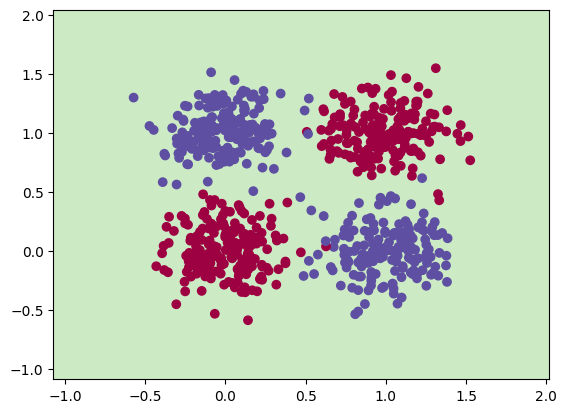

In [20]:
# MODEL 1 here
n0 = 2
n1 = 8
n2 = 2
alpha = 0.1
epochs = 10

# Build a model with 3 layers

myModel1 = MyNeuralNet(n0, n1, n2, alpha)

for i in range(epochs):
    myModel1.fit(X_train, y_train, epochs, X_val, y_val)
    print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

#Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)


Epoch 0/100 - loss: 719.886755 - accuracy: 0.513889 - val_loss: 80.086514 - val_accuracy: 0.412500
Epoch 10/100 - loss: 719.608813 - accuracy: 0.513889 - val_loss: 80.498933 - val_accuracy: 0.412500
Epoch 20/100 - loss: 719.597090 - accuracy: 0.513889 - val_loss: 80.584954 - val_accuracy: 0.412500
Epoch 30/100 - loss: 719.595611 - accuracy: 0.513889 - val_loss: 80.602223 - val_accuracy: 0.412500
Epoch 40/100 - loss: 719.594500 - accuracy: 0.513889 - val_loss: 80.605811 - val_accuracy: 0.412500
Epoch 50/100 - loss: 719.593367 - accuracy: 0.513889 - val_loss: 80.606710 - val_accuracy: 0.412500
Epoch 60/100 - loss: 719.592189 - accuracy: 0.513889 - val_loss: 80.607089 - val_accuracy: 0.412500
Epoch 70/100 - loss: 719.590955 - accuracy: 0.513889 - val_loss: 80.607375 - val_accuracy: 0.412500
Epoch 80/100 - loss: 719.589656 - accuracy: 0.513889 - val_loss: 80.607653 - val_accuracy: 0.412500
Epoch 90/100 - loss: 719.588281 - accuracy: 0.513889 - val_loss: 80.607943 - val_accuracy: 0.412500
A

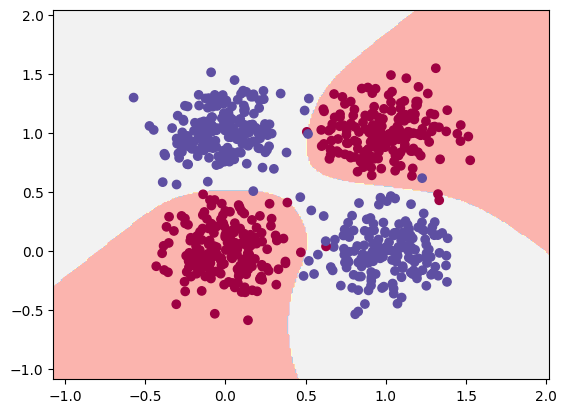

In [21]:
# MODEL 2 here
n0 = 2
n1 = 8
n2 = 2
alpha = 0.30
epochs = 100

# Build a model with 3 layers

myModel1 = MyNeuralNet(n0, n1, n2, alpha)

for i in range(epochs):
    myModel1.fit(X_train, y_train, epochs, X_val, y_val)
    print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

#Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)

Epoch 0/100 - loss: 719.931302 - accuracy: 0.513889 - val_loss: 80.058632 - val_accuracy: 0.412500
Epoch 10/100 - loss: 719.650118 - accuracy: 0.513889 - val_loss: 80.405704 - val_accuracy: 0.412500
Epoch 20/100 - loss: 719.615059 - accuracy: 0.513889 - val_loss: 80.533611 - val_accuracy: 0.412500
Epoch 30/100 - loss: 719.609792 - accuracy: 0.513889 - val_loss: 80.579119 - val_accuracy: 0.412500
Epoch 40/100 - loss: 719.608163 - accuracy: 0.513889 - val_loss: 80.595214 - val_accuracy: 0.412500
Epoch 50/100 - loss: 719.607005 - accuracy: 0.513889 - val_loss: 80.600982 - val_accuracy: 0.412500
Epoch 60/100 - loss: 719.605929 - accuracy: 0.513889 - val_loss: 80.603142 - val_accuracy: 0.412500
Epoch 70/100 - loss: 719.604887 - accuracy: 0.513889 - val_loss: 80.604041 - val_accuracy: 0.412500
Epoch 80/100 - loss: 719.603868 - accuracy: 0.513889 - val_loss: 80.604497 - val_accuracy: 0.412500
Epoch 90/100 - loss: 719.602867 - accuracy: 0.513889 - val_loss: 80.604798 - val_accuracy: 0.412500
A

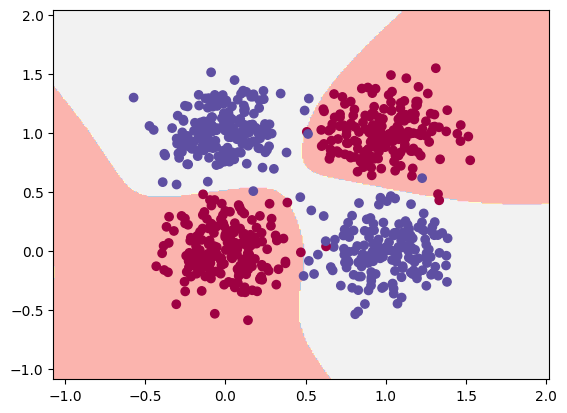

In [22]:
# MODEL 3 here
n0 = 2
n1 = 16
n2 = 2
alpha = 0.20
epochs = 100

# Build a model with 3 layers

myModel1 = MyNeuralNet(n0, n1, n2, alpha)

for i in range(epochs):
    myModel1.fit(X_train, y_train, epochs, X_val, y_val)
    print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

#Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)

In [24]:
# COMPARISONS OF THESE MODELS WITH THE STANDARD LIBRARY MODEL IN TASK 2

learning_rate = 0.05

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_loop(dataloader_test, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.018172  [   32/   23]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.043635 

Epoch 2
-------------------------------
loss: 0.095212  [   32/   23]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.046548 

Epoch 3
-------------------------------
loss: 0.068643  [   32/   23]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.049128 

Epoch 4
-------------------------------
loss: 0.013870  [   32/   23]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.040707 

Epoch 5
-------------------------------
loss: 0.060712  [   32/   23]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.074971 

Epoch 6
-------------------------------
loss: 0.034977  [   32/   23]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.068526 

Epoch 7
-------------------------------
loss: 0.010830  [   32/   23]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.042395 

Epoch 8
-------------------------------
loss: 0.017568  [   32/   23]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.037345 

Epoch 9
----------------

## Reflection
Write at least a paragraph answering these prompts: How did your own network perform? Is there any major differences between the implementations? Finally, reflecting on your experience implementing a learning algorithm for this assignment (Was it hard/easy/fun?, From which part did you learn the most?)!

My network performed quite well. There are however a few major differences between the PyTorch method and my method. Perhaps the most glaring is the huge disparity in the length of code. PyTorch optimizes everything so that you only need a couple main functions. This assignment, particularly making a neural net from scratch, was very challening. However, this however allowed me to learn the most. This is because you had to obtain a deep understanding of the structure of a neural network, and not just memorize some functions in a Python library. 

---
# Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lecture slides on Module 2.
 * Post a question in Piazza.
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or email me <vga8uf@virginia.edu> with subject starting "DS 6050 Assignment 1:...".

Part of the codes used in this assignment is modified from Konstantinos Kitsios under the 3-Clause BSD License. Best of luck and have fun!